In [14]:
from transformers import AutoTokenizer, AutoModel
import senteval
import torch
import torch.nn as nn
import json
import os
from tqdm import tqdm

In [15]:
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader, Dataset
import gzip
import csv

sts_dataset_path = '../datasets/stsbenchmark.tsv.gz'

if not os.path.exists(sts_dataset_path):
    util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)

texts1, texts2 = [], []
with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row['split'] == 'test':
            texts1.append(row['sentence1'])
            texts2.append(row['sentence2'])

class BaseDataset(Dataset):
    def __init__(self, texts1, texts2, scale=None):
        self.texts1, self.texts2 = [], []
        for t1, t2 in zip(texts1, texts2):
            self.texts1.append(t1)
            self.texts2.append(t2)

    def __getitem__(self, idx):
        return (self.texts1[idx], self.texts2[idx])

    def __len__(self):
        return len(self.texts1)

dataset = BaseDataset(texts1, texts2)
loader = DataLoader(dataset, batch_size=128)

In [44]:
DEVICE = "cuda:0"

def batch_to_device(d, device):
    return {k: v.to(device) for k, v in d.items()}
    
class MeanPooling(nn.Module):
    
    def forward(self, x, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(x.size()).float().to(DEVICE)
        emb_sum = torch.sum(x * input_mask_expanded, dim=-2)
        sum_mask = torch.clamp(input_mask_expanded.sum(dim=-2), min=1e-9) # denominator
        emb_mean = emb_sum / sum_mask
        return emb_mean
    
def batch_cos_sim(x, y):
    return (x * y).sum(dim=2) / (x.norm(dim=2, p=2.0) * y.norm(dim=2, p=2.0))
    
class Bert:

    def __init__(self, path=None):
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
        if path is None:
            self.model = AutoModel.from_pretrained("bert-base-cased").to(DEVICE)
        else:
            self.model = torch.load(path).to(DEVICE)
        self.pooling = MeanPooling()
        self.model.eval()
    
    @torch.no_grad()
    def forward(self, loader):
        activations = []
        for _, (t1, t2) in tqdm(enumerate(loader)):
            tokenized1 = self.tokenizer(t1, padding=True, truncation=True, return_tensors="pt")
            tokenized2 = self.tokenizer(t2, padding=True, truncation=True, return_tensors="pt")

            tokenized_device1 = batch_to_device(tokenized1, DEVICE)
            tokenized_device2 = batch_to_device(tokenized2, DEVICE)

            out1 = self.model(**tokenized_device1, output_hidden_states=True).hidden_states
            out_mean1 = self.pooling(torch.stack(out1), tokenized_device1["attention_mask"])

            out2 = self.model(**tokenized_device2, output_hidden_states=True).hidden_states
            out_mean2 = self.pooling(torch.stack(out2), tokenized_device2["attention_mask"])
            
            cos_sim = batch_cos_sim(out_mean1, out_mean2)
            activations.append(cos_sim)
        return torch.cat(activations, dim=1).detach()

class Electra:

    def __init__(self, path=None):
        self.tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
        if path is None:
            self.model = AutoModel.from_pretrained("google/electra-base-discriminator").to(DEVICE)
        else:
            self.model = torch.load(path).to(DEVICE)
        self.pooling = MeanPooling()
        self.model.eval()
    
    @torch.no_grad()
    def forward(self, loader):
        activations = []
        for _, (t1, t2) in tqdm(enumerate(loader)):
            tokenized1 = self.tokenizer(t1, padding=True, truncation=True, return_tensors="pt")
            tokenized2 = self.tokenizer(t2, padding=True, truncation=True, return_tensors="pt")

            tokenized_device1 = batch_to_device(tokenized1, DEVICE)
            tokenized_device2 = batch_to_device(tokenized2, DEVICE)

            out1 = self.model(**tokenized_device1, output_hidden_states=True).hidden_states
            out_mean1 = self.pooling(torch.stack(out1), tokenized_device1["attention_mask"])

            out2 = self.model(**tokenized_device2, output_hidden_states=True).hidden_states
            out_mean2 = self.pooling(torch.stack(out2), tokenized_device2["attention_mask"])
            
            cos_sim = batch_cos_sim(out_mean1, out_mean2)
            activations.append(cos_sim)
        return torch.cat(activations, dim=1).detach()

11it [00:02,  5.04it/s]


torch.Size([13, 1379])


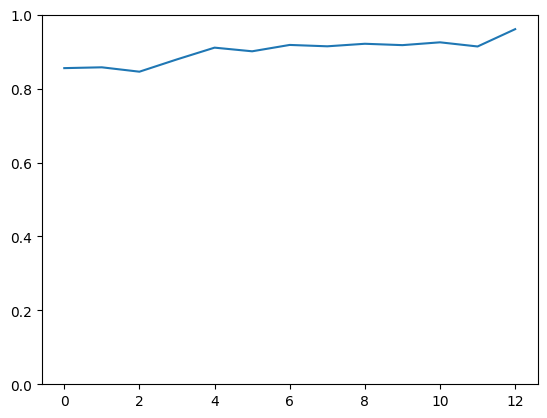

In [48]:
import torch.nn.functional as F 
import matplotlib.pyplot as plt


electra = Electra()
acts = electra.forward(loader)

print(acts.shape)
isotropies = []
for k in range(13):
    isotropies.append(acts[k].mean().cpu().tolist())
    

plt.ylim([0, 1])
plt.plot(list(range(len(isotropies))), isotropies)

11it [00:02,  4.64it/s]


torch.Size([13, 1379])


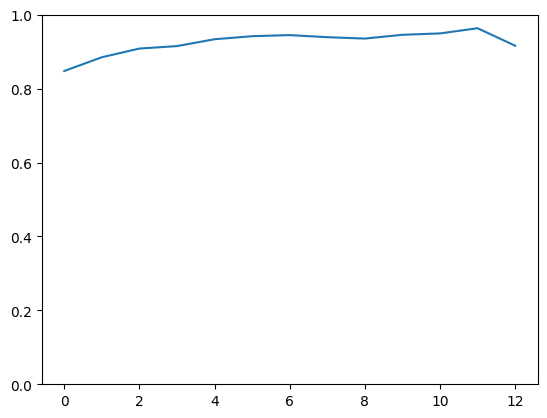

In [47]:
bert = Bert()
acts = bert.forward(loader)

print(acts.shape)
isotropies = []
for k in range(13):
    isotropies.append(acts[k].mean().cpu().tolist())
    
plt.ylim([0, 1])
plt.plot(list(range(len(isotropies))), isotropies)